### Regime Identification in Multivariate Time-series

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import regimes
import numpy as np
import pandas as pd
import seaborn as sns
from clasp import ClaSP
import datasets as dataset
from scipy import stats
from spdms import getSPDMs
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

np.random.seed(1)

In [3]:
# Normalization (Standard)
def normalize(data, type='minmax'):

    if type=='std':
        return (np.array(data) - np.mean(data))/np.std(data)
        
    elif type=='minmax':
        return (np.array(data) - np.min(data))/(np.max(data) - np.min(data))

In [4]:
def difference_dataframe(df, interval=1):
    """
    Applies differencing to all columns of a DataFrame while maintaining timestamps.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with timestamps as index.
        interval (int): The differencing interval. Default is 1.

    Returns:
        pandas.DataFrame: DataFrame with differenced values and timestamps.
    """
    # Extract timestamps if they are set as index
    timestamps = df.index
    
    # Apply differencing to all columns
    diff_df = df.apply(lambda x: np.diff(x, n=interval))
    
    # Restore timestamps to the differenced DataFrame
    diff_df.index = timestamps[1:]  # We lose one timestamp due to differencing
    
    return diff_df


In [5]:
# Function to convert timestamp to formatted date
def convert_timestamp(timestamp):
    # Assuming the timestamp format is 'YYMMDD'
    timestamp = str(timestamp)
    year = int(timestamp[:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])

    # Convert to datetime object
    date_obj = datetime(year, month, day)

    # Format the datetime object as 'DD-Mon-YYYY'
    formatted_date = date_obj.strftime('%d-%b-%Y')

    return formatted_date

In [6]:
def add_date_column(dataframe, starting_date):
    """
    Add a 'date' column to the DataFrame based on the 'day' column and starting date.

    Parameters:
    - dataframe: DataFrame with a 'day' column representing the day of the year.
    - starting_date: Starting date in the format 'DD-MMM-YYYY' (e.g., '01-Jan-2001').

    Returns:
    - DataFrame with the added 'date' column.
    """
    # Number of samples in the data
    num_samples = len(dataframe)

    # Convert the starting date to a datetime object
    start_date = pd.to_datetime(starting_date, format="%d-%b-%Y")

    # Add a new 'date' column based on 'day', 'month', and dynamically assigned 'year'
    dataframe['Date'] = (start_date + pd.to_timedelta(dataframe.index, unit='D')).strftime("%d-%b-%Y")

    return dataframe

In [7]:
# Function to trim time part from date string and use month names abbreviation
def trim_time_and_format(date_string):
    datetime_object = datetime.strptime(date_string, "%d-%b-%Y") # "%Y-%m-%d %H:%M:%S"
    return datetime_object #.strftime("%Y %b")

In [9]:
# Load data
file_path = r"/home/ahmad/Projects/gCause/datasets/fluxnet2015/FLX_FR-Pue_FLUXNET2015_SUBSET_2000-2014_2-4/FLX_FR-Pue_FLUXNET2015_SUBSET_DD_2000-2014_2-4.csv"  # Replace with the actual file path
# file_path = r'../datasets/synthetic_datac.csv'
# file_path = r'/home/ahmad/Projects/RegimeIdentification/'
data = regimes.read_file(file_path)
start_date = '01-Jan-2002'
end_date ='31-Dec-2007'
col_list = ['TIMESTAMP', 'SW_IN_F', 'TA_F', 'GPP_NT_VUT_50', 'RECO_NT_VUT_50']
# Convert the 'date' column to datetime objects
data['TIMESTAMP'] = data['TIMESTAMP'].apply(convert_timestamp)

data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data = data[(data['TIMESTAMP'] >= start_date) & (data['TIMESTAMP'] <= end_date)][col_list]

# # # -------------- FLUXNET2015-----------------------
# offset = 365
# start, end = 2*offset , 3*offset

# df = {'R$_g$': rg[start: end], 'T$_{air}$': temp[start: end], 'GPP': gpp[start: end], 'R$_{eco}$': reco[start: end]}   # 
# data = pd.DataFrame(df, columns=['R$_g$', 'T$_{air}$', 'GPP', 'R$_{eco}$'])  #, 'GPP', 'R$_{eco}$'
# # -------------------------------------------------


In [216]:
if len(data.columns)==1:
    data = regimes.shift_and_fill_mean(data, 3)
data

,TIMESTAMP,SW_IN_F,TA_F,GPP_NT_VUT_50,RECO_NT_VUT_50
731,2002-01-01,39.520,1.469,1.497140,1.17799
732,2002-01-02,27.295,2.691,1.233890,1.26954
733,2002-01-03,7.616,4.341,0.306711,1.42968
734,2002-01-04,3.647,4.068,0.176032,1.44458
735,2002-01-05,36.795,4.177,1.474480,1.49326
...,...,...,...,...,...
2917,2007-12-27,89.770,4.998,1.982720,1.20277
2918,2007-12-28,93.042,2.528,1.683500,1.01482
2919,2007-12-29,87.940,3.283,1.440250,1.00989
2920,2007-12-30,94.610,7.685,1.765110,1.19101


In [217]:
# # Apply the function to the entire column
# time_column_exist, col_name = regimes.find_time_related_columns(data)
# print(time_column_exist, col_name)
# if time_column_exist:
#     data['Date'] = data['Date'].apply(trim_time_and_format)

In [218]:

data.set_index('TIMESTAMP', inplace=True)
data = difference_dataframe(data, interval=1)
data.head()

,SW_IN_F,TA_F,GPP_NT_VUT_50,RECO_NT_VUT_50
TIMESTAMP,,,,
2002-01-02,-12.225,1.222,-0.263250,0.09155
2002-01-03,-19.679,1.650,-0.927179,0.16014
2002-01-04,-3.969,-0.273,-0.130679,0.01490
2002-01-05,33.148,0.109,1.298448,0.04868
2002-01-06,52.137,-2.169,0.579520,-0.13820


In [219]:
# start, end = '2014-11-01', '2016-12-30'

# Appy mask get a segment from time series
# mask = (data['DateTime'] > '2014-11-01') & (data['DateTime'] <= '2015-12-28')
# data = data.loc[mask]

# data = data.fillna(method='pad')
# data = data.set_index('DateTime')
# data = data[start: end]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2002-01-02 to 2007-12-31
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SW_IN_F         2190 non-null   float64
 1   TA_F            2190 non-null   float64
 2   GPP_NT_VUT_50   2190 non-null   float64
 3   RECO_NT_VUT_50  2190 non-null   float64
dtypes: float64(4)
memory usage: 85.5 KB


In [220]:
data.isnull().sum()

SW_IN_F           0
TA_F              0
GPP_NT_VUT_50     0
RECO_NT_VUT_50    0
dtype: int64

In [221]:
# Loop through columns and fill NaN values with mean
for column in data.columns:
    if data[column].isnull().any():
        mean_value = data[column].mean()
        data[column].fillna(mean_value, inplace=True)

In [222]:
# data = data.dropna(how='any',axis=0) 
# data = data.drop(columns=['Date'])
columns = data.columns
data.isnull().sum()

SW_IN_F           0
TA_F              0
GPP_NT_VUT_50     0
RECO_NT_VUT_50    0
dtype: int64

In [223]:
# toplot = ['Z1', 'Z2','Z5']
# data = data[toplot]
# data.head()

In [224]:
data = data.apply(normalize)

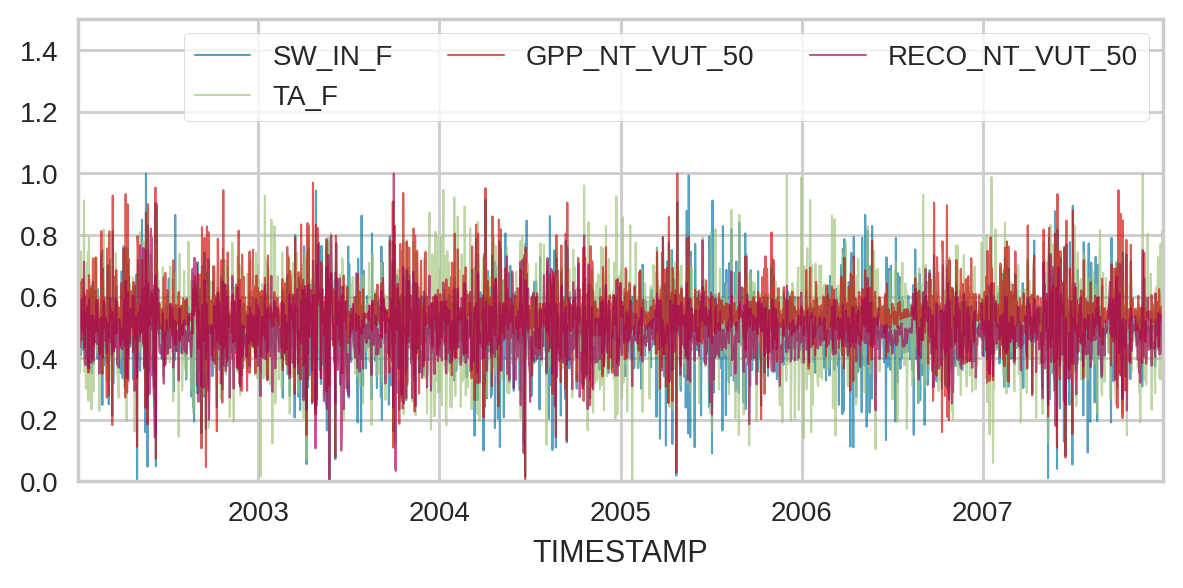

In [225]:
# toplot = [ 'rain', 'snow_load', 'pressure_outside','gw_mb', 'gw_sg', 'gw_west', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = ['Z1', 'Z2','Z5']
toplot = columns

for i in toplot:
    data[i].plot(use_index=True, figsize=(7, 3), linewidth=0.75, alpha=0.66)
    plt.legend(toplot, frameon=True, ncol=3)

plt.ylim(0, 1.5)
# plt.gcf().autofmt_xdate()
# plt.legend(['Temperature', 'Ground Water', 'Strain_EW', 'Strain_NS'])
# plt.legend(['$Z_{1}$', '$Z_{2}$', '$Z_{3}$'])
# plt.savefig("synreg25Apr.png")
plt.show()

In [238]:
# Desired number of clusters. Set k=None to let the algorithm aumotically find opitmal k.
k = 3    # k=None

# Sliding window size
winsize = 40 # 155

# distance metrics
metricE = 'Euclidean'
metricR = 'Riemannian'

# Specify reduced dimension size, default is dim='full' for no dimension reduction.
dim = 'full' 

# Retrieve regimes with their corresponding indices
clusters, cluster_idx, *_ = regimes.get_regimes(data, winsize, metricR, k, dim)

Regimes:(0, 0) (0, 40) (1, 80) (1, 120) (2, 160) (2, 200) (1, 240) (1, 280) (0, 320) (0, 360) (0, 400) (1, 440) (1, 480) (2, 520) (2, 560) (1, 600) (1, 640) (0, 680) (0, 720) (0, 760) (0, 800) (1, 840) (1, 880) (2, 920) (1, 960) (1, 1000) (0, 1040) (0, 1080) (0, 1120) (1, 1160) (1, 1200) (2, 1240) (2, 1280) (2, 1320) (1, 1360) (0, 1400) (0, 1440) (0, 1480) (0, 1520) (2, 1560) (2, 1600) (2, 1640) (2, 1680) (1, 1720) (0, 1760) (0, 1800) (0, 1840) (0, 1880) (1, 1920) (1, 1960) (1, 2000) (2, 2040) (1, 2080) (0, 2120)


In [239]:
clusters_extended = []

for i in range(len(clusters)):

    val = clusters[i]
    for j in range(winsize):
        clusters_extended.append(val)
        
        
print(len(clusters_extended), data.shape)

2160 (2190, 4)


In [240]:
datanew = data.iloc[:len(clusters_extended), :].copy()
datanew['Clusters'] = clusters_extended

<Figure size 3000x800 with 0 Axes>

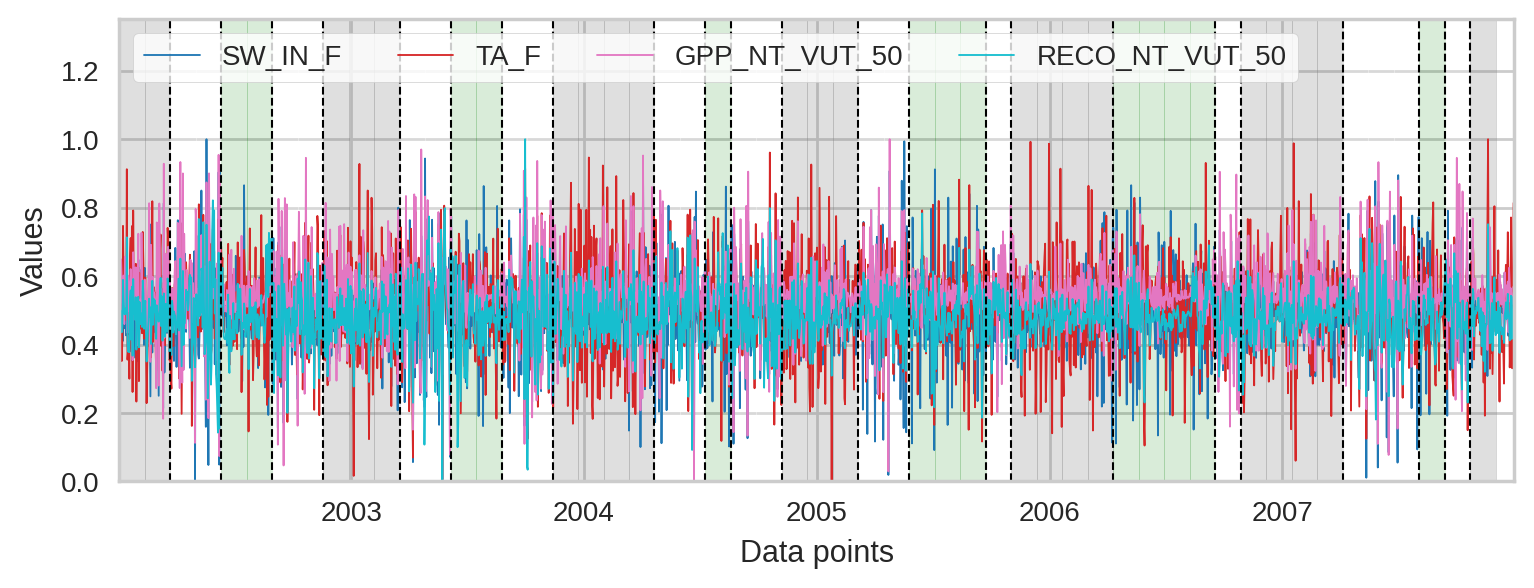

In [241]:
var_to_plot = toplot
regimes.visualize(data, var_to_plot, clusters, cluster_idx, winsize, dtype='real')